In [52]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383

def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        #print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")

        if i >= 1:
            energy_diff = abs(energies[-1] - energies[-2])
            diff_to_target = abs(energies[-1] - E_set)
            if  diff_to_target < 0.135440:
                print(f" Converged at step {i + 1}!")
                print(f" Energy change ΔE = {energy_diff:.2e} Ha < 1e-6")
                print(f" different from E_set = {diff_to_target:.2e} Ha < 1e-3")
                break
        
        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)

basis = ["ecr", "id", "rz", "sx", "x"]
basis2= ['rz', 'rx', 'cx']  # IBM 超导平台的典型基础门集
basis3 = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']

coupling_map = CouplingMap.from_full(4)


# 定义线性拓扑：0–1–2–3
linear_coupling = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])
transpiled_circuit= transpile(
    final_circuit,
    basis_gates=basis3,  # 典型 IBM 超导平台的基础门集合
    coupling_map=linear_coupling,  # 线性拓扑
    optimization_level=1
)

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")



 Converged at step 72!
 Energy change ΔE = 3.99e-03 Ha < 1e-6
 different from E_set = 1.33e-01 Ha < 1e-3
rz: 3963
sx: 3659
cz: 3018
rx: 1152
rzz: 432


In [53]:
gate_counts = transpiled_circuit.count_ops()
total_count = sum(gate_counts.values())  # 所有 gate 总数
print(f"Total gate count: {total_count}")

Total gate count: 12224


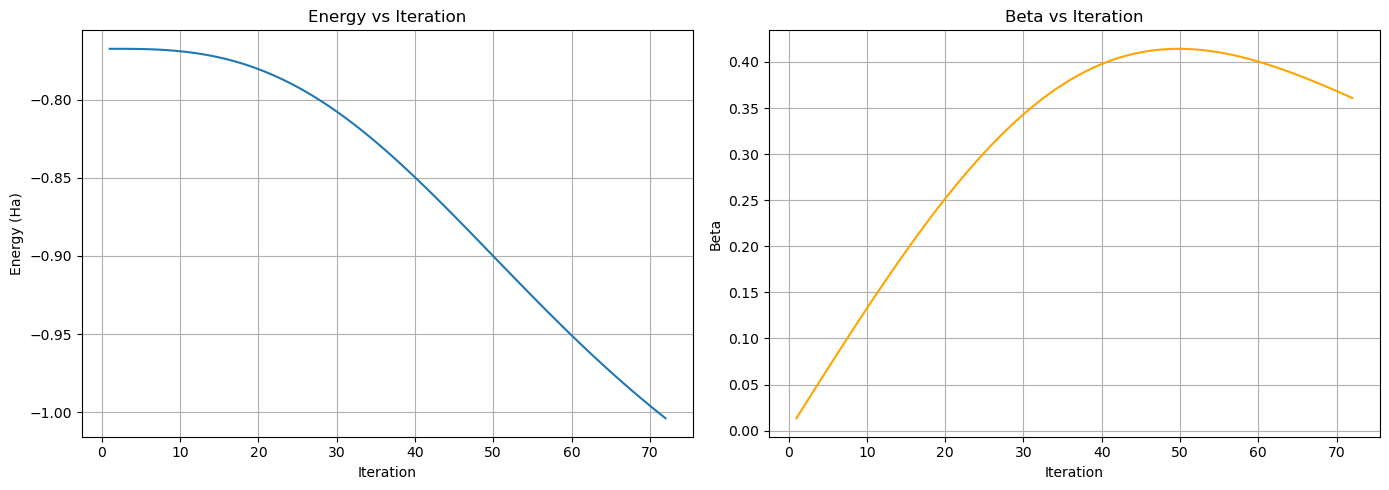

In [54]:
import matplotlib.pyplot as plt

# 假设 s_energies 和 s_beta 已经从主循环中返回
# 由于 s_beta 比 s_energies 多一个初始项（beta_0），绘图时要截取对应范围

# 生成迭代步列表
iterations = list(range(1, len(s_energies) + 1))

# 创建两个子图
plt.figure(figsize=(14, 5))

# 第一个子图：Energy vs Iteration
plt.subplot(1, 2, 1)
plt.plot(iterations, s_energies)
plt.title('Energy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.grid(True)

# 第二个子图：Beta vs Iteration
plt.subplot(1, 2, 2)
plt.plot(iterations, s_beta[1:], color='orange')
plt.title('Beta vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Beta')
plt.grid(True)

plt.tight_layout()
plt.show()


In [55]:
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())
print(cost_h)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81280876+0.j,  0.17110568+0.j, -0.22250985+0.j,  0.17110568+0.j,
 -0.22250985+0.j,  0.12051037+0.j,  0.16859357+0.j,  0.16584097+0.j,
  0.0453306 +0.j,  0.0453306 +0.j,  0.0453306 +0.j,  0.0453306 +0.j,
  0.16584097+0.j,  0.17432084+0.j,  0.12051037+0.j])


In [56]:
a=pow(0.999,8045)
print(a)

0.0003194131399083989
